https://www.science.org/doi/10.1126/science.1127647

https://github.com/L1aoXingyu/pytorch-beginner/blob/9c86be785c7c318a09cf29112dd1f1a58613239b/08-AutoEncoder/conv_autoencoder.py

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    pad_for_windowing,
    window_session,
    optimization_loop
)
from lib.models import LinearAutoencoder, ConvAutoencoder
from tqdm import tqdm
import plotly.express as px
from datetime import timedelta
from sklearn.model_selection import train_test_split

In [ ]:
WINSIZE = 101
DEVICE = 'cuda:0'
RAW_DIR = Path('/home/musa/datasets/eating_raw/')

In [ ]:
recordings = []
for rec_dir in RAW_DIR.iterdir():
    recordings.append(rec_dir)
    print(rec_dir.name)

In [ ]:
accelerations = []
for session_dir in recordings:
    accel_file = session_dir / f'acceleration-{session_dir.name}.csv'
    acceleration = pd.read_csv(accel_file,skiprows=1).rename({'x': 'x_acc', 'y': 'y_acc', 'z': 'z_acc'}, axis=1)
    # acceleration = acceleration.dropna()

    acceleration_start_time_seconds = float(pd.read_csv(session_dir / accel_file, nrows=1,header=None).iloc[0,0].split()[-1])/1000
    acceleration.timestamp = ((acceleration.timestamp - acceleration.timestamp[0])*1e-9)+acceleration_start_time_seconds # get timestamp in seconds

    accelerations.append(acceleration)

    print(f'Index: {len(accelerations)-1}, Date: {session_dir.name}, nSamples: {len(acceleration)}, Time Elapsed: {timedelta(seconds=acceleration.timestamp.iloc[-1] - acceleration.timestamp.iloc[0])}')


In [ ]:
dim_amt = 20
i = 5
fig = px.line(accelerations[i][::dim_amt], x=accelerations[i].index[::dim_amt], y=['x_acc','y_acc','z_acc'])
fig.show(renderer='browser')

In [ ]:
skip_idxs = [2, 12, 13]
test_idxs = [1, 5,10]

In [ ]:
Xtr = []
Xte = []

for i,accel in enumerate(accelerations):
    if i in skip_idxs:
        continue

    X = torch.Tensor(accel[['x_acc','y_acc','z_acc']].values)
    X = pad_for_windowing(X, WINSIZE)
    X = window_session(X, WINSIZE)
    print(X.shape)

    if i in test_idxs:
        Xte.append(X)
    else:
        Xtr.append(X)

Xtr = torch.cat(Xtr)
Xte = torch.cat(Xte)

trainloader = DataLoader(TensorDataset(Xtr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte), batch_size=64)

torch.save(trainloader, 'pytorch_datasets/trainloader_11-10-23.pt')
torch.save(testloader, 'pytorch_datasets/testloader_11-10-23.pt')

In [100]:
model = ConvAutoencoder(winsize=WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [ ]:
losses = []
test_losses = []
pbar = tqdm(range(10))
for epoch in pbar:
    lossi = 0
    test_lossi = 0

    for X in trainloader:
        X = X[0].to(DEVICE)

        # Foward Pass
        logits = model(X)
        loss = criterion(logits, X)

        # Backwards Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Sum Loss
        lossi += loss.item()
    
    # Test model
    for X in testloader:
        X = X[0].to(DEVICE)
        logits = model(X)
        test_lossi += criterion(logits, X).item()

    losses.append(lossi/len(trainloader))
    test_losses.append(test_lossi/len(testloader))
    pbar.set_description(f'Epoch {epoch}: Train Loss: {losses[-1]:.5}, Test Loss: {test_losses[-1]:.5}')

    plt.plot(losses)
    plt.plot(test_losses)

In [ ]:
torch.save(model.state_dict(), 'dev/autoencorder.pt')

# Evaluate

In [101]:
testloader = torch.load('pytorch_datasets/testloader_11-10-23.pt')
trainloader = torch.load('pytorch_datasets/trainloader_11-10-23.pt')

In [102]:
model.load_state_dict(torch.load('dev/autoencoder2/best_model-39.pt'))

<All keys matched successfully>

In [103]:
# Recreate a signal with trained model

i = test_idxs[2]
# i = 9

acceleration = accelerations[i]

Xte = torch.Tensor(acceleration[['x_acc','y_acc','z_acc']].values)
Xte = pad_for_windowing(Xte, WINSIZE)
Xte = window_session(Xte, WINSIZE)

testloader = DataLoader(TensorDataset(Xte), batch_size=64)

Xpred = []
for X in tqdm(testloader):
    X = X[0].to(DEVICE)
    logits = model(X)
    Xpred.append(logits)

Xpred = torch.cat(Xpred)
Xpred = Xpred.view(-1,3,101)[:,:,50].T # unwindow

acceleration['x_pred'] = Xpred[0].cpu().detach()
acceleration['y_pred'] = Xpred[1].cpu().detach()
acceleration['z_pred'] = Xpred[2].cpu().detach()

100%|██████████| 10876/10876 [00:04<00:00, 2456.92it/s]


In [104]:
dim_amt = 20
fig = px.line(acceleration[::dim_amt], x=acceleration.index[::dim_amt], y=['x_acc','y_acc','z_acc', 'x_pred', 'y_pred', 'z_pred'])
fig.show(renderer='browser')

# Stuff

In [ ]:
logits = 0
for X in trainloader:
    X = X[0][0].view(3,101).to(DEVICE)
    logits = model.encoder[0](X)
    break

In [ ]:
plt.plot(X[0].cpu().detach())

In [ ]:
plt.plot(logits[2].cpu().detach())

In [ ]:
print(model.state_dict().keys())
plt.plot(model.state_dict()['encoder.0.weight'][3][0].cpu().detach())
plt.plot(model.state_dict()['encoder.0.weight'][3][1].cpu().detach())
plt.plot(model.state_dict()['encoder.0.weight'][3][2].cpu().detach())

# Linear Classifier

In [152]:
from lib.modules import (
    read_and_window_nursing_session
)
from lib.utils import (
    plot_and_save_cm,
    plot_and_save_losses,
    summary
)

In [108]:
raw_dir = Path("/home/musa/datasets/nursingv1")
label_dir = Path("/home/musa/datasets/eating_labels")
WINSIZE = 101
DEVICE = 'cuda:0'

In [110]:
train_sessions = [25, 67, 42]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [135]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

In [149]:

class EncoderClassifier(nn.Module):
    def __init__(self, autoencoder: ConvAutoencoder):
        super().__init__()
        self.winsize = autoencoder.winsize
        self.encoder = autoencoder.encoder
        self.encoder.requires_grad_ = False
        self.classifier = nn.Sequential(
            nn.Linear(in_features=52, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        x = x.view(-1,3,self.winsize)
        x = self.encoder(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

ae_model = ConvAutoencoder(winsize=WINSIZE)
ae_model.load_state_dict(torch.load('dev/autoencoder2/best_model-39.pt'))
model = EncoderClassifier(ae_model).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [150]:
optimization_loop(model, trainloader, testloader, criterion, optimizer, 10, DEVICE, Path('dev/encoderclass2'))

Epoch 9: Train Loss: 0.31577: Dev Loss: 0.53295: 100%|██████████| 10/10 [02:12<00:00, 13.26s/it]


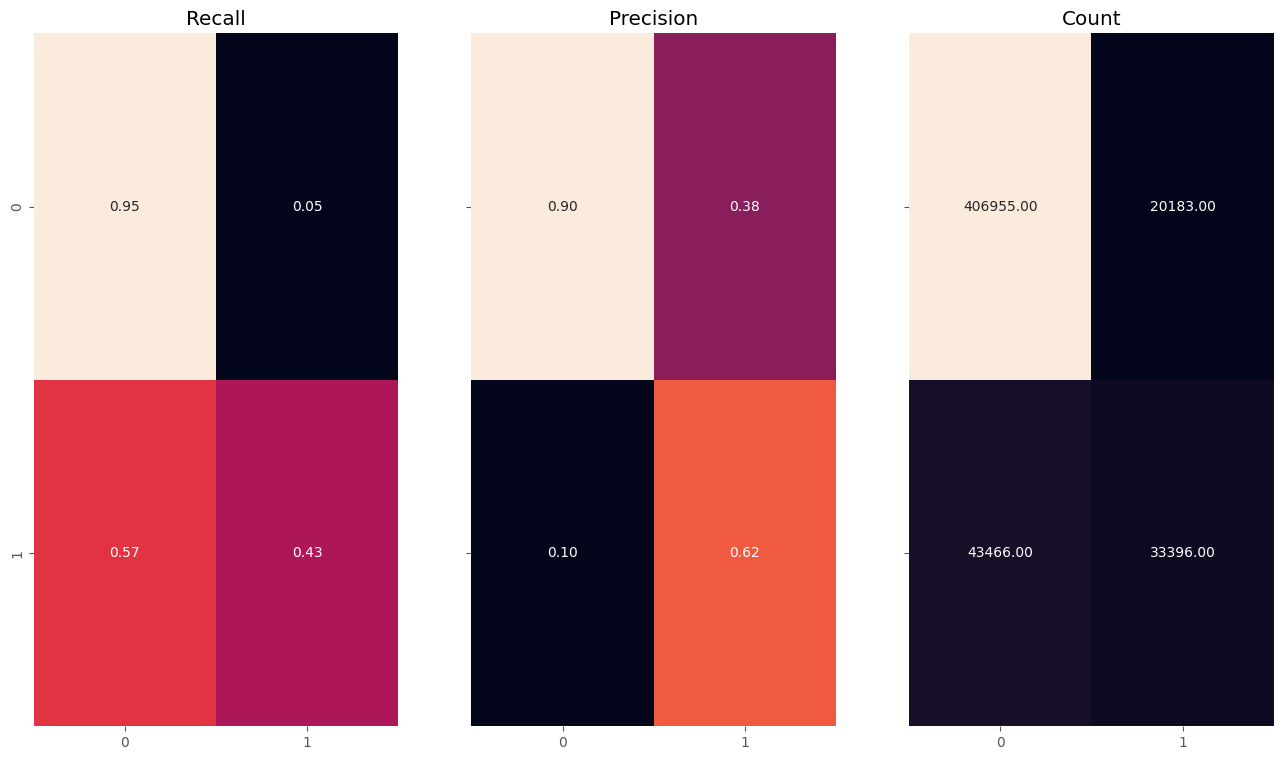

Metric        Value
---------  --------
loss       0.315772
precision  0.623304
recall     0.434493
f1         0.512048


In [153]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

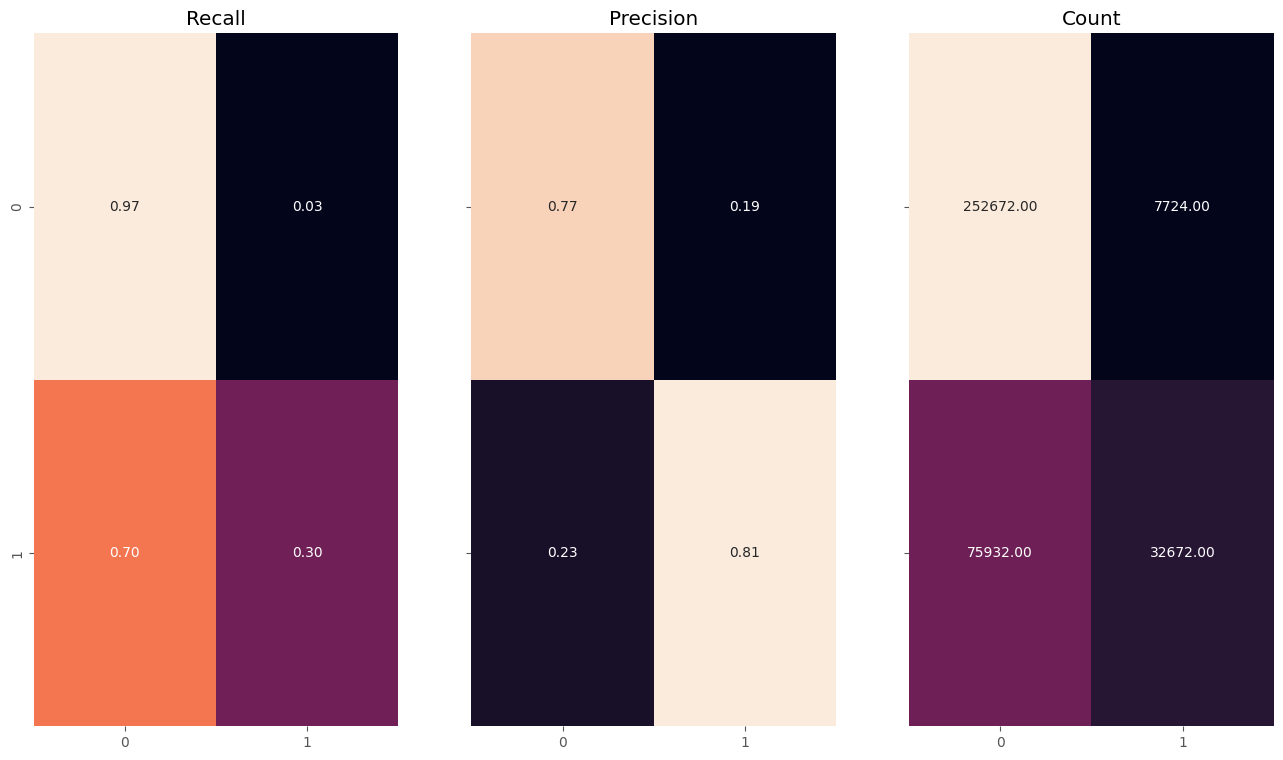

Metric        Value
---------  --------
loss       0.53295
precision  0.808793
recall     0.300836
f1         0.43855


In [154]:
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)